# <center><b> Práctica 2 de Laboratorio 5 </b><br><u> Espectroscopía Láser </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

In [8]:
import pyvisa as visa
import numpy as np
import matplotlib.pyplot as plt
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

# Formato para los gráficos:
MARKER_FMT = dict(markersize=6, markeredgewidth=0.25, markeredgecolor='k',)
ERROR_FMT = dict(ecolor='k', capsize=2,)

from instrumental import TDS1002B
try:
    rm.close()
except NameError:
    pass
rm = visa.ResourceManager()

instruments = rm.list_resources()
print(instruments)

for inst in instruments:
    if ('C102220::0::INSTR' in inst
        or 'C108013::0::INSTR' in inst):  # Ojo si nos cambian el osciloscopio
        print('Osciloscopio TDS1002B detectado:',
            f'\nID: {inst}')
        osci = TDS1002B(inst)
        
    elif 'M00404166::0::INSTR' in inst:
        print('Laser Diode Temperature Controller detectado:',
            f'\nID: {inst}')

('USB0::1689::867::C108013::0::INSTR',)
Osciloscopio TDS1002B detectado: 
ID: USB0::1689::867::C108013::0::INSTR
TEKTRONIX,TDS 1002B,C108013,CF:91.1CT FV:v22.13



In [2]:
FREQS_RUBIDIO85 = [361.78e6, 3.0357324390e9, 150.659e9+377.1073085690e12-1.2648885163e9, 150.659e9+377.1073085690e12, 377.1073085690e12-210.923e6- 1.2648885163e9, 377.1073085690e12-210.923e6+1.7708439228e9]
FREQS_RUBIDIO85.append(150.659e9+377.1073085690e12-1.2648885163e9+FREQS_RUBIDIO85[1])
FREQS_RUBIDIO85 = np.sort(FREQS_RUBIDIO85, )

FREQS_RUBIDIO87 = [814.5e6, 377.1052058e12, 388.1120405e12, 377.1043913e12, 377.111226e12, 6.834682610904290e9]   # Hz
FREQS_RUBIDIO87 = np.sort(FREQS_RUBIDIO87, )

def plot_channels(
    tiempo: np.ndarray, channel1: np.ndarray, channel2: np.ndarray, volt_scale="V"
) -> None:
    scale_dict = {
        "V": 1e0,
        "mV": 1e3,
    }

    plt.figure()
    plt.plot(
        tiempo * 1e3,
        channel1 * scale_dict[volt_scale],
        "^-",
        **MARKER_FMT,
        alpha=0.5,
        label="CH1"
    )
    plt.plot(
        tiempo * 1e3,
        channel2 * scale_dict[volt_scale],
        ".-",
        **MARKER_FMT,
        alpha=0.5,
        label="CH2"
    )
    plt.legend()
    plt.xlabel("$\mathrm{Tiempo}\quad\mathrm{[ms]}$")
    plt.ylabel("$\mathrm{Voltaje}\quad\mathrm{[" + volt_scale + "]}$")


    # plt.figure()
    # plt.scatter(
    #     channel1 * scale_dict[volt_scale],
    #     channel2 * scale_dict[volt_scale],
    #     s=7 * (1 - tiempo / tiempo[-1]),
    #     c=tiempo,
    #     linewidths=0.45,
    #     edgecolors="k",
    #     zorder=10,
    # )
    # plt.xlabel("$\mathrm{Canal\ 1}\quad\mathrm{[" + volt_scale + "]}$")
    # plt.ylabel("$\mathrm{Canal\ 2}\quad\mathrm{[" + volt_scale + "]}$")



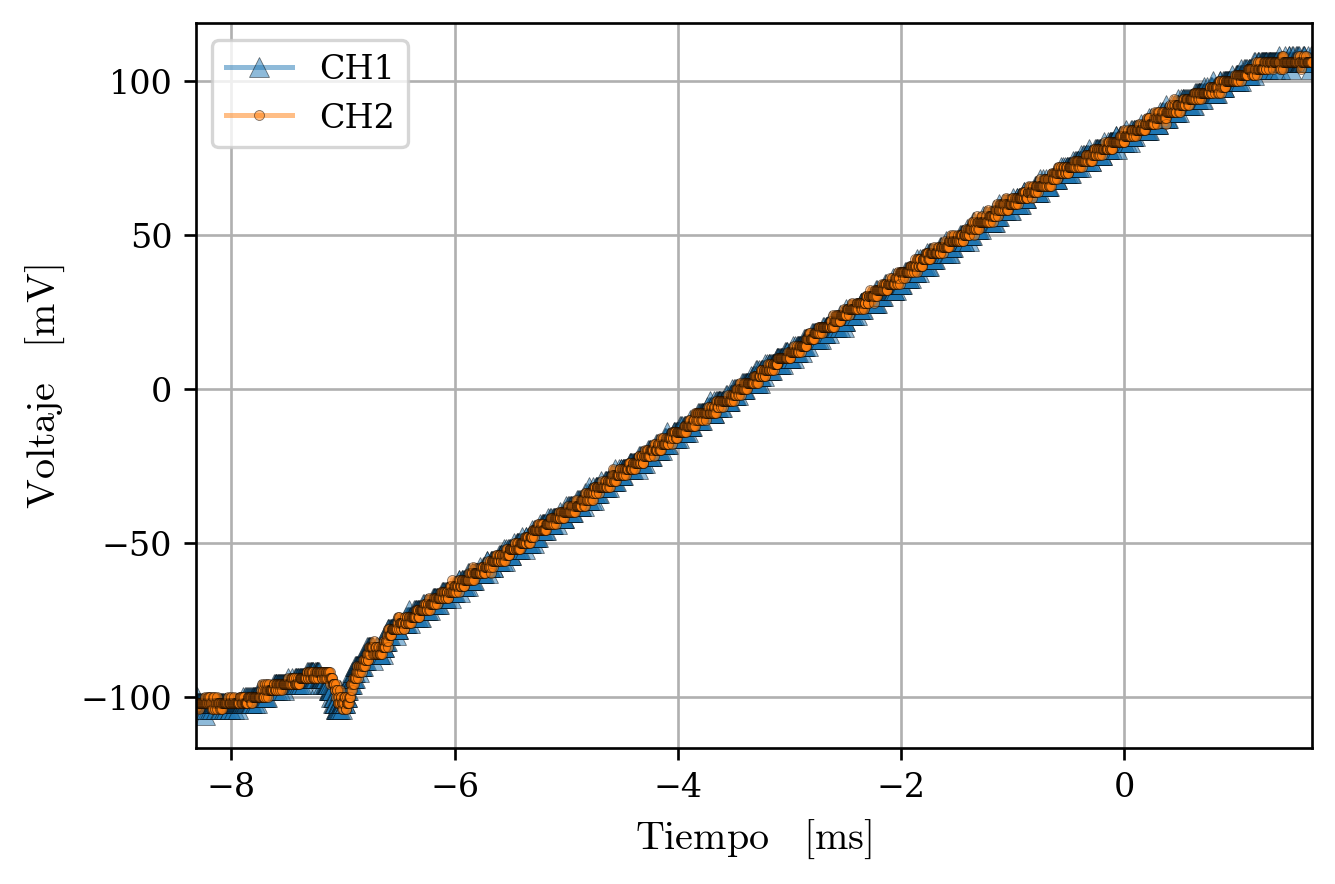

In [11]:

tiempo, channel1 = osci.read_data(0)  # s, V
tiempo, channel2 = osci.read_data(1)  # s, V

plot_channels(tiempo, channel1, channel2, 'mV')
# plt.xlim(-3.3, -1.9)
plt.show()

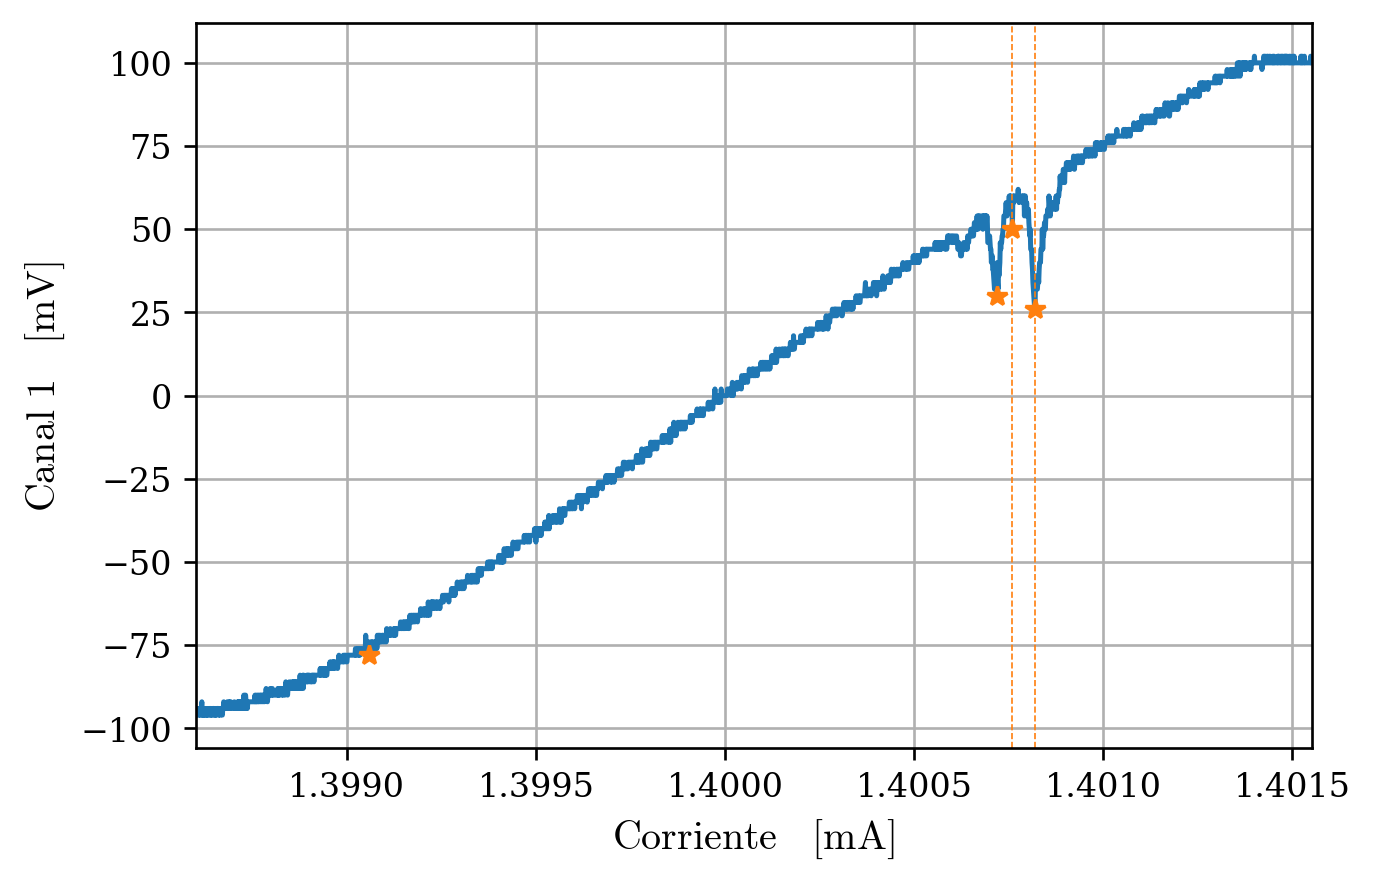

In [29]:
# from scipy.signal import sawtooth
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# def triangular(t, frecuencia, amplitud, fase, offset):
#     return amplitud*sawtooth(t*frecuencia*2*np.pi + fase, width=0.5) + offset

def lineal(t, a, b):
    return a*t + b

amp_scale = 'mA'
volt_scale = 'mV'
SCALE = {'V': 1e0, 'mV': 1e3, 'A': 1e0, 'mA': 1e3, 'MHz': 1e-6, 'GHz': 1e-9, 'THz': 1e-12}
# popt, pcov = curve_fit(triangular, tiempo, channel1, p0=[50, 0.1, 0.7, 200])

# Hipotesis: los picos de tensión se asocian a los picos de corriente
corriente_setpoint = 1.4e-3  # A : Valor medio de las oscilaciones
corriente_depth = 0.1/100
corriente_max = corriente_setpoint*(1+corriente_depth)  # A
corriente_min = corriente_setpoint*(1-corriente_depth)  # A
Temperatura = 22.5  # °C : fija
corriente_rango = corriente_max - corriente_min  # A
t_max = tiempo[np.argmax(channel1)]  # s
t_min = tiempo[np.argmin(channel1)]  # s
m = (corriente_max - corriente_min)/(t_max - t_min)  # A/s

corriente1 = m*(tiempo - t_min) + corriente_min  # A
popt, pcov = curve_fit(lineal, corriente1, channel1)

peaks = find_peaks(-(channel1 - lineal(corriente1, *popt)), distance=15, prominence=0.01)[0]


plt.figure()

plt.plot(corriente1*SCALE[amp_scale], channel1*SCALE[volt_scale])
plt.plot(corriente1[peaks]*SCALE[amp_scale], channel1[peaks]*SCALE[volt_scale], '*')
plt.axvline(corriente1[peaks[-2]]*SCALE[amp_scale], c='C1', lw=0.5, ls='--')
plt.axvline(corriente1[peaks[-1]]*SCALE[amp_scale], c='C1', lw=0.5, ls='--')
plt.ylabel("$\mathrm{Canal\ 1}\quad\mathrm{[" + volt_scale + "]}$")
plt.xlabel('$\mathrm{Corriente}\quad\mathrm{['+ amp_scale +']}$')
plt.show()


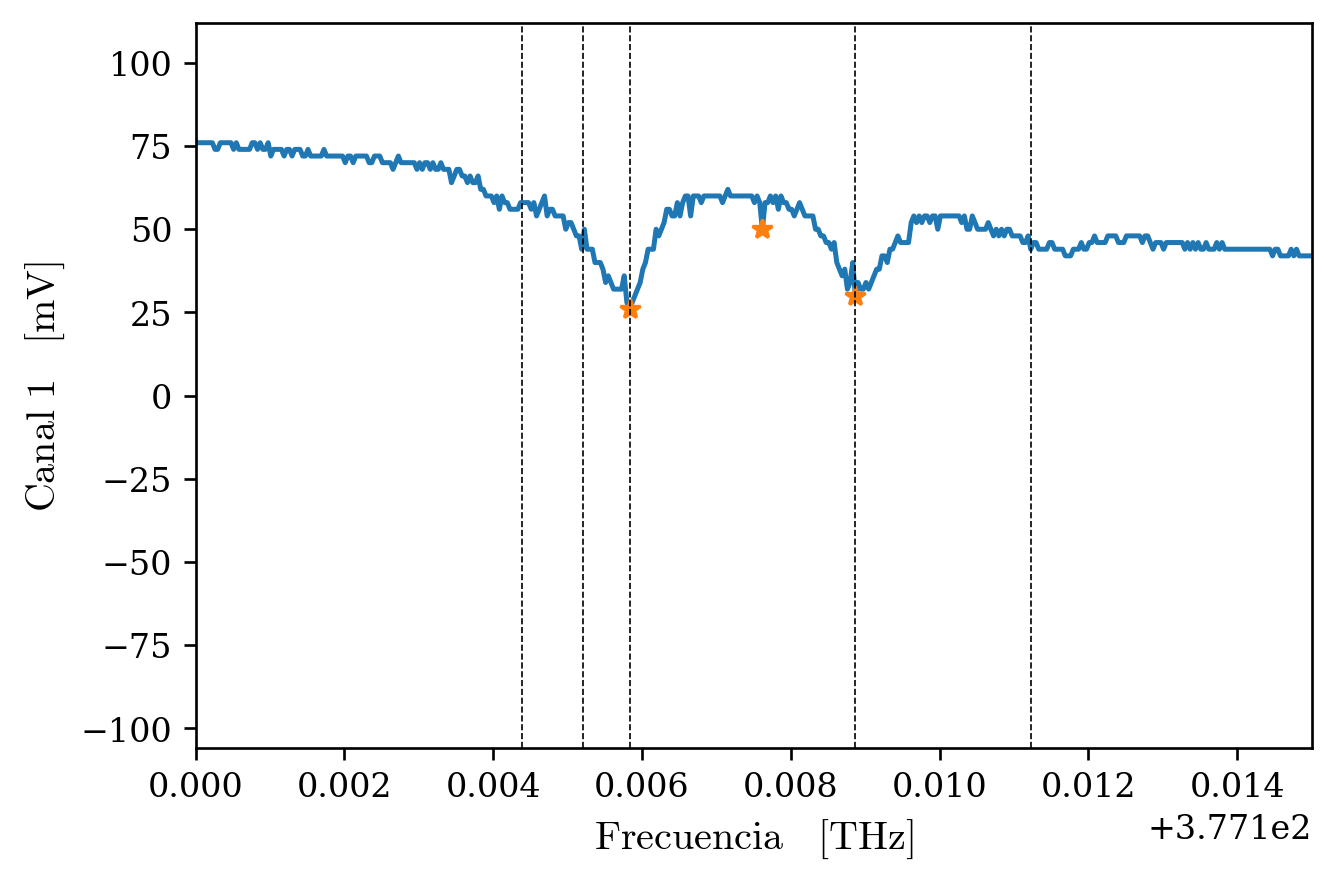

In [30]:
def corriente_a_frecuencia(corriente, freq_ru, corriente_forzada):
    m = -(freq_ru.max() - freq_ru.min())/(corriente_forzada.max() - corriente_forzada.min())
    return m*(corriente - corriente_forzada.min()) + freq_ru.max()

picos_forzados = corriente1[peaks[[-3, -1]]]  # A
freqs_rubidio = np.sort(np.concatenate([FREQS_RUBIDIO85, FREQS_RUBIDIO87]))  # Hz

# for idx1 in range(4, 8):
#     for idx2 in range(idx1+1, 9):
idx1 = 6
idx2 = 7
frecuencias = corriente_a_frecuencia(corriente1, freqs_rubidio[[idx1, idx2]], picos_forzados)
plt.figure()
hertz_scale = 'THz'

plt.plot(frecuencias*scale_dict[hertz_scale], channel1*scale_dict[volt_scale])
plt.plot(frecuencias[peaks]*scale_dict[hertz_scale], channel1[peaks]*scale_dict[volt_scale], '*')
for linea in freqs_rubidio:
    plt.axvline(linea*scale_dict[hertz_scale], c='k', lw=0.5, ls='--')

plt.ylabel("$\mathrm{Canal\ 1}\quad\mathrm{[" + volt_scale + "]}$")
plt.xlabel('$\mathrm{Frecuencia}\quad\mathrm{['+ hertz_scale +']}$')
# plt.xlim(frecuencias.min()*scale_dict[hertz_scale], frecuencias.max()*scale_dict[hertz_scale])
plt.xlim(377.10, 377.115)
plt.grid(False)
plt.show()

    # freqs_rubidio*scale_dict['MHz']


In [164]:
freqs_rubidio[[6, 7]]*scale_dict['THz']

array([377.10583276, 377.10886849])

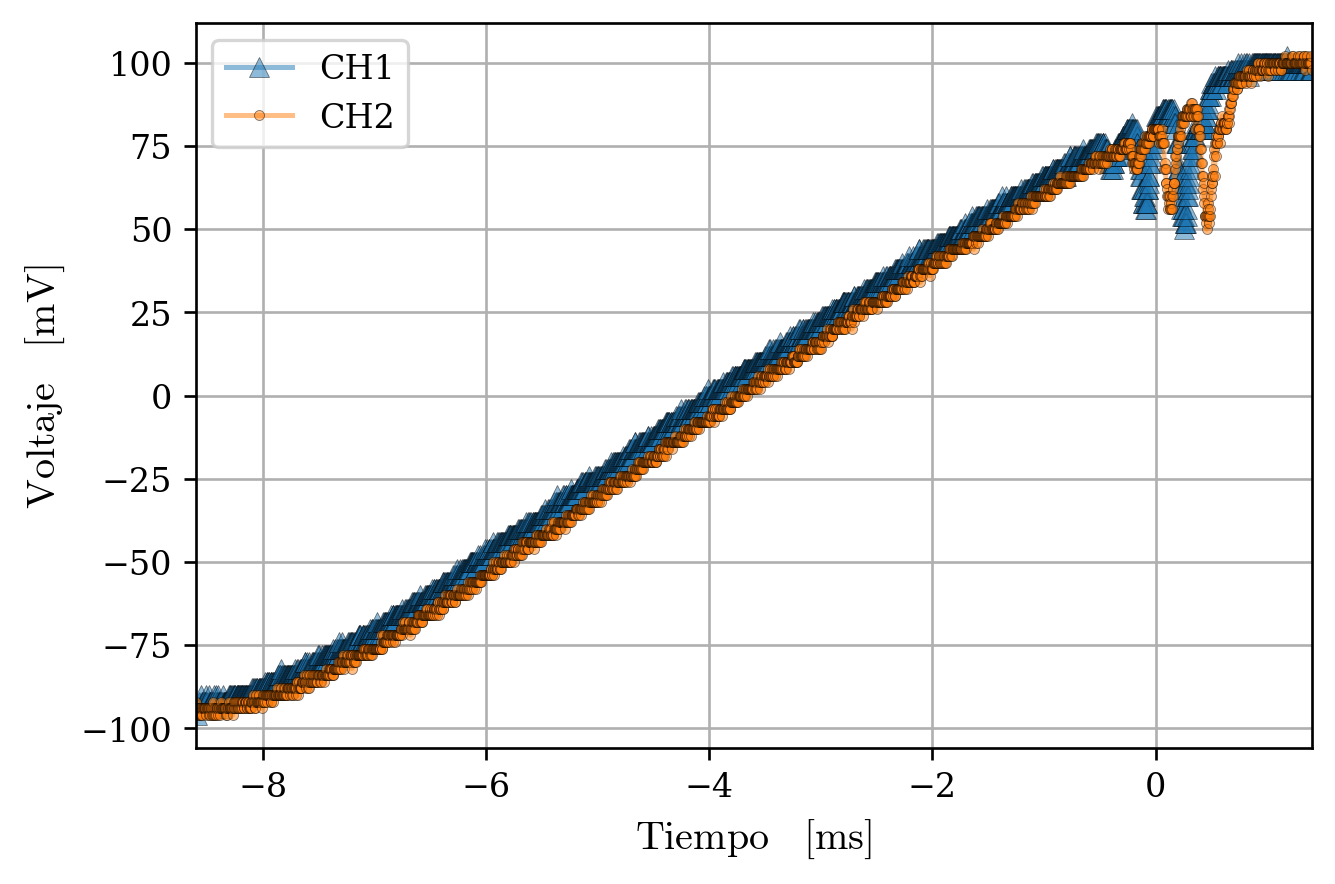

In [31]:
tiempo, channel1 = osci.read_data(0)  # s, V
tiempo, channel2 = osci.read_data(1)  # s, V

plot_channels(tiempo, channel1, channel2, 'mV')
# plt.xlim(-3.3, -1.9)
plt.show()

## Save files:

Columnas: `tiempo [s], voltaje [V], voltaje [V]`

prueba0.npy y prueba1.npy : 
```
        corriente_setpoint = 1.4e-3  # A
        corriente_depth = 0.1/100
        Temperatura = 22.5  # °C : fija
```
 pendiente{i}.npy: 
```
        corriente_setpoint = 1.4e-3  # A
        corriente_depth = 0.1/100
        Temperatura = i×10⁻²  # °C
```

In [32]:
def save_osci_data(t, *channels, filename=None):
    if filename is None:
        raise ValueError('Especificar `filename`.')
    osci_data = np.array([t, *channels],)
    np.save(filename, osci_data, )
    return None

filename = input('Filename: ')+'.npy'
save_osci_data(tiempo, channel1, channel2, filename=filename)

## Load files:

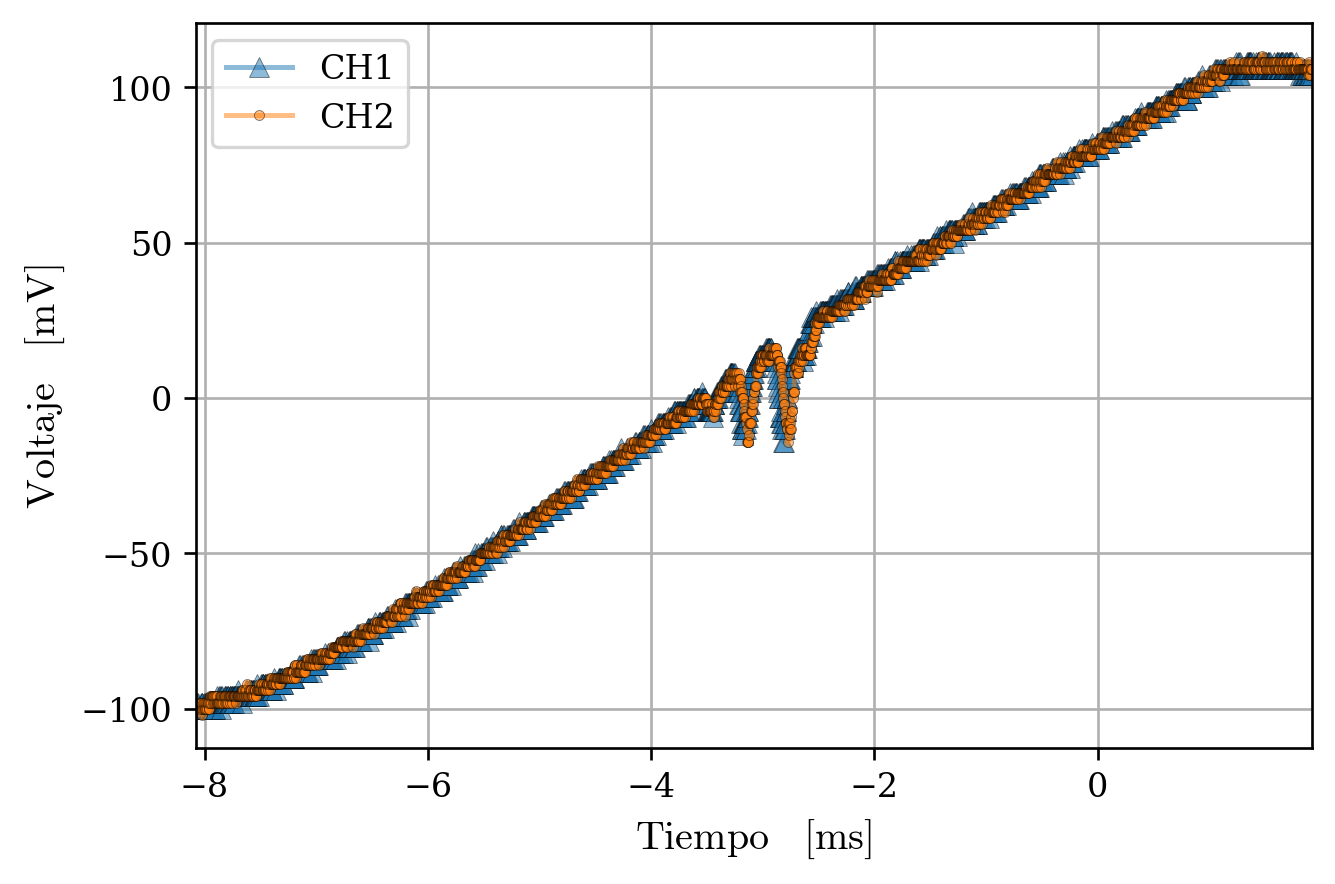

In [10]:
# tiempo, channel1, channel2 = np.load('pendiente0.npy')
plot_channels(tiempo, channel1, channel2, 'mV')